# Khám phá dữ liệu

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import warnings

# Tắt cảnh báo
warnings.simplefilter(action='ignore', category=FutureWarning) 

# Import thư viện xử lý tiếng Việt
from underthesea import word_tokenize

# Load stopwords từ file vietnamese-stopwords.txt
try:
    with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        STOPWORDS = set([line.strip() for line in f.readlines() if line.strip()])
    print(f"✓ Đã load {len(STOPWORDS)} stopwords từ vietnamese-stopwords.txt")
except FileNotFoundError:
    # Nếu không có file, dùng list cơ bản
    STOPWORDS = set(['và', 'của', 'có', 'được', 'này', 'cho', 'không', 'tại', 'là', 
                     'đã', 'trong', 'các', 'để', 'một', 'với', 'những', 'từ', 'như', 'hay',
                     'rất', 'rồi', 'bị', 'bởi', 'cả', 'cái', 'chỉ', 'cũng', 'đang', 'khi',
                     'lại', 'lên', 'mà', 'nếu', 'nhưng', 'phải', 'qua', 'sau', 'thì', 'trên'])
    print(f"⚠ Không tìm thấy vietnamese-stopwords.txt")
    print(f"✓ Sử dụng {len(STOPWORDS)} stopwords cơ bản")
except Exception as e:
    STOPWORDS = set()
    print(f"❌ Lỗi khi load stopwords: {e}")

file = "vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv"
file2 = "vlsp2018_hotel/2-VLSP2018-SA-Hotel-dev.csv"
file3 = "vlsp2018_restaurant/1-VLSP2018-SA-Restaurant-train.csv"

⚠ Không load được NLTK stopwords: No such file or directory: 'C:\\Users\\home\\AppData\\Roaming\\nltk_data\\corpora\\stopwords\\vietnamese'
✓ Sử dụng 19 stopwords cơ bản


In [23]:
# Đổi file csv thành dạng utf8 cho đỡ bị lỗi format tiếng việt
df = pd.read_csv(file,encoding="utf-8")
df.to_csv(file,index=False, encoding='utf-8-sig')

def fix_excel_format(text):
    if isinstance(text, str) and text.strip().startswith('-'):
        return "'" + text
    return text

if 'Review' in df.columns:
    df['Review'] = df['Review'].apply(fix_excel_format)
df.to_csv(file,index=False, encoding='utf-8-sig')

In [24]:
df = pd.read_csv(file)
df

,Review,FACILITIES#CLEANLINESS,FACILITIES#COMFORT,FACILITIES#DESIGN&FEATURES,FACILITIES#GENERAL,FACILITIES#MISCELLANEOUS,FACILITIES#PRICES,FACILITIES#QUALITY,FOOD&DRINKS#MISCELLANEOUS,FOOD&DRINKS#PRICES,...,ROOMS#PRICES,ROOMS#QUALITY,ROOM_AMENITIES#CLEANLINESS,ROOM_AMENITIES#COMFORT,ROOM_AMENITIES#DESIGN&FEATURES,ROOM_AMENITIES#GENERAL,ROOM_AMENITIES#MISCELLANEOUS,ROOM_AMENITIES#PRICES,ROOM_AMENITIES#QUALITY,SERVICE#GENERAL
0,Rộng rãi KS mới nhưng rất vắng. Các dịch vụ ch...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Địa điểm thuận tiện, trong vòng bán kính 1,5km...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Phục vụ, view đẹp, vị trí",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"thuận tiện , sạch sẽ , vui vẻ hài lòng",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Vị trí đẹp; Có quán bar view đẹp; Nhân viên th...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Đối diện thung lũng Một kỳ nghỉ tuyệt vời ở Sa...,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2996,Cảm nhận của cá nhân về Sapa View: Phòng ốc đẹ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2997,"Xin chào Chudu24,Xin cám ơn dịch vụ booking củ...",0,0,0,0,0,0,0,0,2,...,0,0,0,0,3,0,0,0,0,1
2998,"Đầu tiên về ưu điểm:- Phòng sạch sẽ, nội thất ...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [25]:
def perform_eda(file_path, title):
    # 1. Đọc dữ liệu (Sử dụng utf-8)
    df = pd.read_csv(file_path, encoding='utf-8')

    # Tách cột Review và các cột nhãn (Aspect#Sentiment)
    review_col = 'Review'
    label_cols = [col for col in df.columns if col != review_col]

    # --- 1: ĐẾM SỐ MẪU MỖI LỚP ---
    sentiment_counts = df[label_cols].melt(var_name='Aspect', value_name='Sentiment')
    sentiment_summary = sentiment_counts[sentiment_counts['Sentiment'] != 0]['Sentiment'].value_counts().sort_index()
    
    label_map = {1: 'Positive', 2: 'Negative', 3: 'Neutral'}
    sentiment_summary.index = sentiment_summary.index.map(label_map)

    # --- 2: ĐỘ DÀI CÂU (Word count) ---
    df['word_count'] = df[review_col].apply(lambda x: len(str(x).split()))

    # --- 3: TỪ XUẤT HIỆN NHIỀU NHẤT ---
    all_words_raw = " ".join(df[review_col].astype(str)).lower()
    all_words_clean = re.sub(r'[^\w\s]', '', all_words_raw) # Xóa dấu câu
    words = all_words_clean.split()
    top_words = Counter(words).most_common(20)

    # --- TRỰC QUAN HÓA ---
    # Đổi thành 1 hàng 4 cột để thêm WordCloud
    fig, axes = plt.subplots(1, 4, figsize=(25, 8))

    # Plot 1: Phân bố nhãn cảm xúc
    sns.barplot(x=sentiment_summary.index, y=sentiment_summary.values, ax=axes[0], palette='viridis', hue=sentiment_summary.index, legend=False)
    axes[0].set_title(f'Phân bố nhãn cảm xúc ({title})')
    axes[0].set_ylabel('Số lượng mẫu')

    # Plot 2: Phân bố độ dài câu
    sns.histplot(df['word_count'], bins=30, kde=True, ax=axes[1], color='orange')
    axes[1].set_title(f'Phân bố độ dài câu ({title})')
    axes[1].set_xlabel('Số lượng từ')

    # Plot 3: Top 10 từ phổ biến
    top_df = pd.DataFrame(top_words[:10], columns=['Word', 'Count'])
    sns.barplot(x='Count', y='Word', data=top_df, ax=axes[2], palette='magma', hue='Word', legend=False)
    axes[2].set_title(f'Top 10 từ xuất hiện nhiều nhất ({title})')

    # Plot 4: WordCloud
    wc = WordCloud(width=800, height=800, background_color='white', colormap='plasma').generate(all_words_raw)
    axes[3].imshow(wc, interpolation='bilinear')
    axes[3].axis('off')
    axes[3].set_title(f'WordCloud ({title})')

    plt.tight_layout()
    plt.show()

    # In thông tin thống kê cơ bản
    print(f"Tổng số dòng: {len(df)}")
    print(f"Độ dài câu trung bình: {df['word_count'].mean():.2f} từ")
    print("-" * 30)

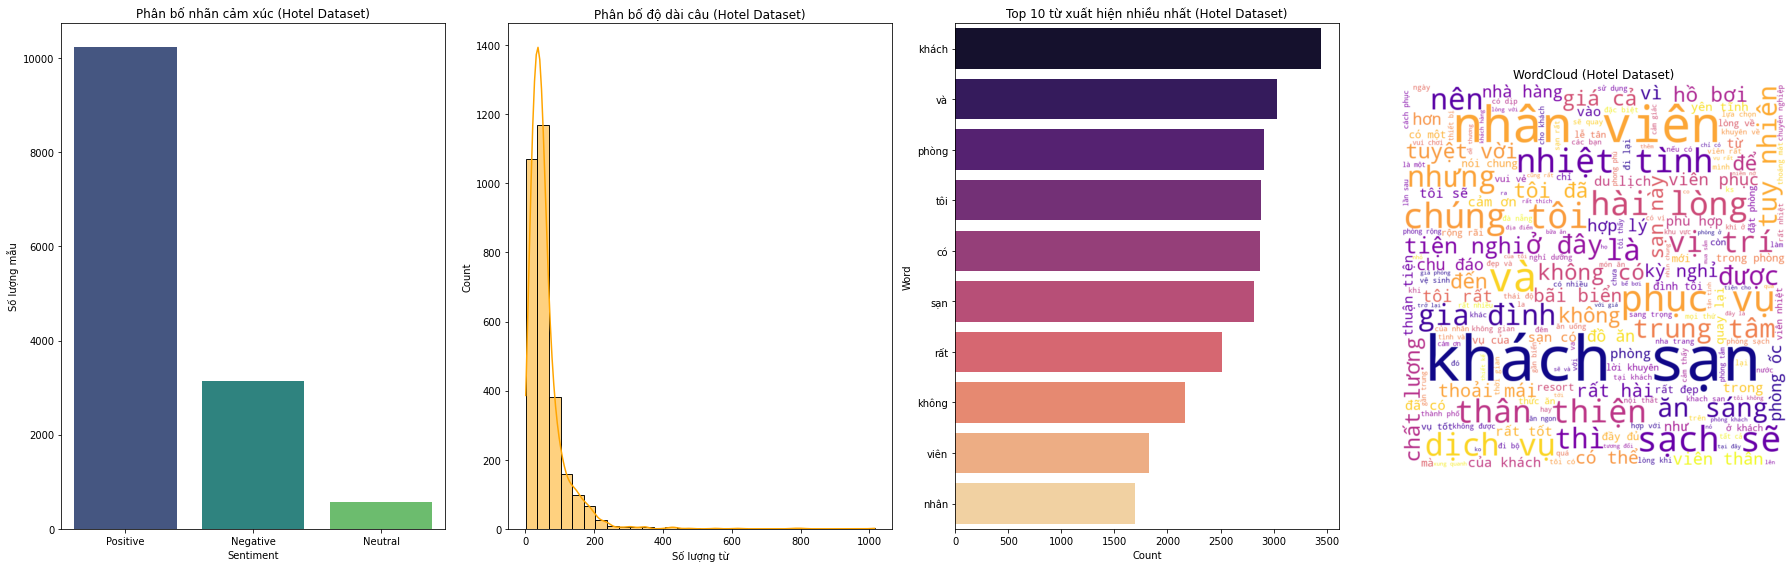

Tổng số dòng: 3000
Độ dài câu trung bình: 58.42 từ
------------------------------


In [26]:
# Thực thi với file 
perform_eda(file, "Hotel Dataset")

KeyboardInterrupt: 

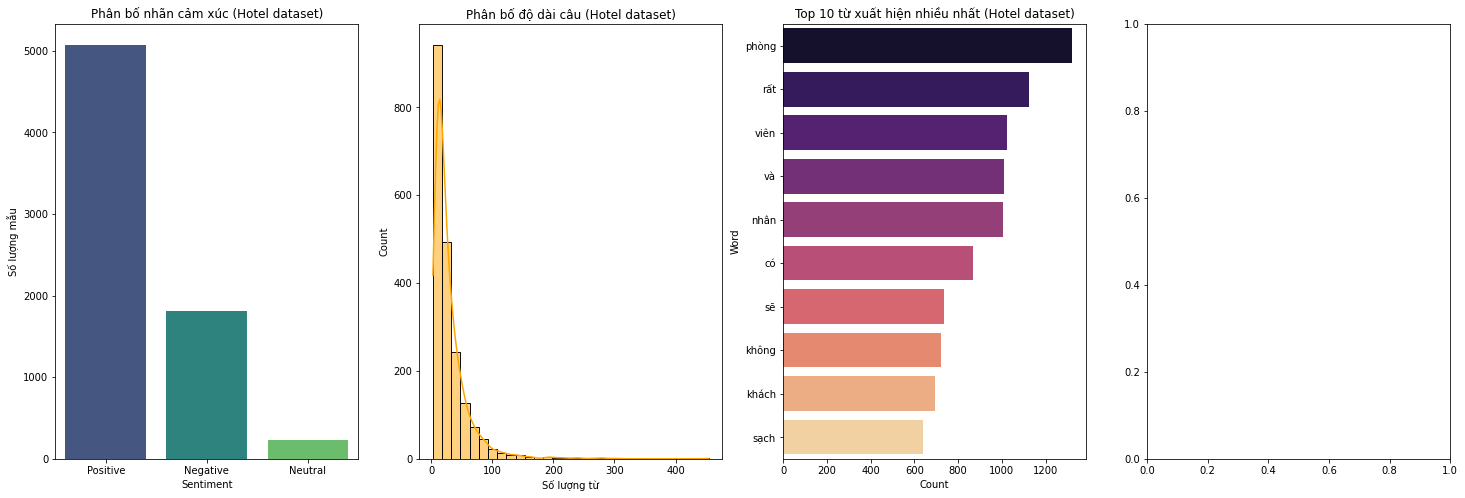

In [27]:
perform_eda(file2,"Hotel dataset")

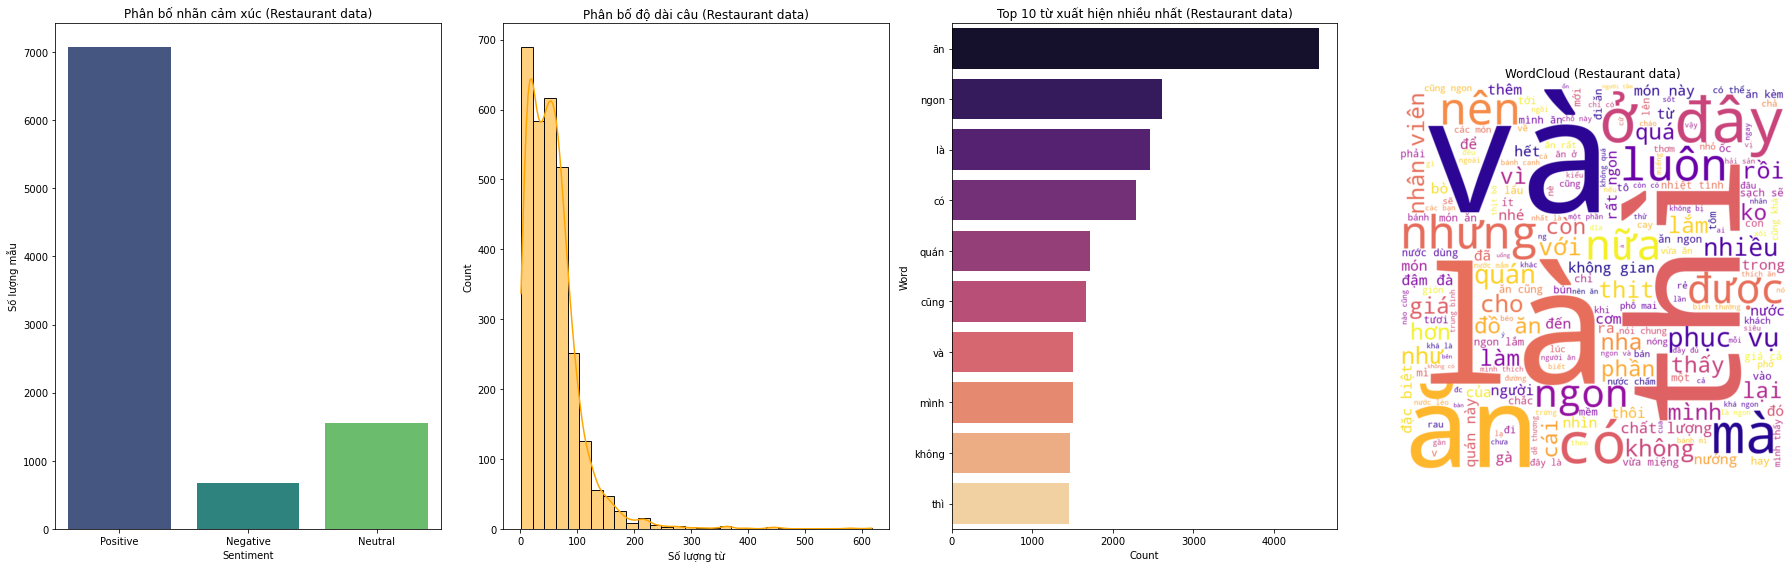

Tổng số dòng: 2961
Độ dài câu trung bình: 56.16 từ
------------------------------


In [ ]:
perform_eda(file3,"Restaurant data")

# Tiền xử lý dữ liệu

In [ ]:
# Với Tiếng Việt, ta cần chuẩn hóa thành chữ thường, loại bỏ các kí tự đặc biệt, emoji, khoảng trắng
# Bổ sung: Chuẩn hóa teencode, tách từ và loại bỏ stopwords

# Load teencode từ file teencode.txt
TEENCODE = {}
try:
    with open('teencode.txt', 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line and ',' in line:
                teen, standard = line.split(',', 1)
                TEENCODE[teen.strip()] = standard.strip()
    print(f"Đã load {len(TEENCODE)} teencode mappings từ file teencode.txt")
except FileNotFoundError:
    print("! Không tìm thấy file teencode.txt, sử dụng dictionary rỗng")
except Exception as e:
    print(f"! Lỗi khi load teencode: {e}")

print(f"Sử dụng {len(STOPWORDS)} stopwords\n")

def normalize_text(text):
    """
    Chuẩn hóa văn bản đầy đủ:
    1. Xóa URL, emoji
    2. Chuyển về viết thường
    3. Chuẩn hóa teencode
    4. Xóa dấu câu và ký tự đặc biệt
    5. Tách từ (tokenize)
    6. Loại bỏ stopwords
    7. Xóa khoảng trắng thừa
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # 1. Xóa URL (http, https, www)
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    
    # 2. Xóa emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # 3. Chuyển về viết thường
    text = text.lower()
    
    # 4. Chuẩn hóa teencode (thay thế từng từ)
    words = text.split()
    words = [TEENCODE.get(word, word) for word in words]
    text = ' '.join(words)
    
    # 5. Xóa dấu câu và ký tự đặc biệt (chỉ giữ chữ cái, số, khoảng trắng)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 6. Xóa khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 7. Tách từ tiếng Việt (word tokenization)
    try:
        text = word_tokenize(text, format="text")
    except:
        pass  # Nếu lỗi thì giữ nguyên text
    
    # 8. Loại bỏ stopwords (sử dụng stopwords đã load từ underthesea)
    words = text.split()
    words = [word for word in words if word not in STOPWORDS and len(word) > 1]
    text = ' '.join(words)
    
    return text.strip()

# Load tất cả các file dataset
hotel_train_path = "vlsp2018_hotel/1-VLSP2018-SA-Hotel-train.csv"
hotel_dev_path = "vlsp2018_hotel/2-VLSP2018-SA-Hotel-dev.csv"
hotel_test_path = "vlsp2018_hotel/3-VLSP2018-SA-Hotel-test.csv"

restaurant_train_path = "vlsp2018_restaurant/1-VLSP2018-SA-Restaurant-train.csv"
restaurant_dev_path = "vlsp2018_restaurant/2-VLSP2018-SA-Restaurant-dev.csv"
restaurant_test_path = "vlsp2018_restaurant/3-VLSP2018-SA-Restaurant-test.csv"

# Đọc và chuẩn hóa các dataset
datasets = {}
print("=== BẮT ĐẦU TIỀN XỬ LÝ DỮ LIỆU ===\n")

for name, path in [
    ("hotel_train", hotel_train_path),
    ("hotel_dev", hotel_dev_path),
    ("hotel_test", hotel_test_path),
    ("restaurant_train", restaurant_train_path),
    ("restaurant_dev", restaurant_dev_path),
    ("restaurant_test", restaurant_test_path)
]:
    df = pd.read_csv(path, encoding='utf-8')
    original_count = len(df)
    
    # Áp dụng chuẩn hóa cho cột Review
    print(f"Đang xử lý {name}...", end=' ')
    df['Review'] = df['Review'].apply(normalize_text)
    
    # Kiểm tra và loại bỏ dữ liệu trùng lặp (dựa trên cột Review)
    duplicates_count = df.duplicated(subset=['Review']).sum()
    df = df.drop_duplicates(subset=['Review'], keep='first')
    
    # Loại bỏ các review rỗng sau khi xử lý
    df = df[df['Review'].str.len() > 0]
    final_count = len(df)
    
    datasets[name] = df
    print(f"✓")
    print(f"  Ban đầu: {original_count} | Trùng lặp: {duplicates_count} | Sau xử lý: {final_count}\n")

print("\n=== HOÀN THÀNH TIỀN XỬ LÝ ===")
print(f"Tổng Hotel: {sum([len(datasets[k]) for k in datasets.keys() if 'hotel' in k])} mẫu")
print(f"Tổng Restaurant: {sum([len(datasets[k]) for k in datasets.keys() if 'restaurant' in k])} mẫu")

print("\n--- Ví dụ sau khi tiền xử lý đầy đủ (Hotel Train) ---")
for i in range(100):
    print(f"{i+1}. {datasets['hotel_train']['Review'].iloc[i]}")

Đã load 121 teencode mappings từ file teencode.txt
Sử dụng 19 stopwords

=== BẮT ĐẦU TIỀN XỬ LÝ DỮ LIỆU ===

Đang xử lý hotel_train... ✓
  Ban đầu: 3000 | Trùng lặp: 60 | Sau xử lý: 2940

Đang xử lý hotel_dev... ✓
  Ban đầu: 2000 | Trùng lặp: 19 | Sau xử lý: 1981

Đang xử lý hotel_test... ✓
  Ban đầu: 600 | Trùng lặp: 0 | Sau xử lý: 600

Đang xử lý restaurant_train... ✓
  Ban đầu: 2961 | Trùng lặp: 11 | Sau xử lý: 2950

Đang xử lý restaurant_dev... ✓
  Ban đầu: 1290 | Trùng lặp: 1 | Sau xử lý: 1289

Đang xử lý restaurant_test... ✓
  Ban đầu: 500 | Trùng lặp: 0 | Sau xử lý: 500


=== HOÀN THÀNH TIỀN XỬ LÝ ===
Tổng Hotel: 5521 mẫu
Tổng Restaurant: 4739 mẫu

--- Ví dụ sau khi tiền xử lý đầy đủ (Hotel Train) ---
1. rộng_rãi khách_sạn mới nhưng rất vắng dịch_vụ chất_lượng chưa cao thiếu
2. địa_điểm thuận_tiện vòng bán_kính km nhiều quán ăn ngon
3. phục_vụ view đẹp vị_trí
4. thuận_tiện sạch_sẽ vui_vẻ hài_lòng
5. vị_trí đẹp quán bar view đẹp nhân_viên thân_thiện
6. co view huong ho tay sach s